# Import data csv dari Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Menyiapkan Library

In [3]:
!pip install xlsxwriter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.8 MB/s eta 0:00:00


# Persiapkan Data untuk dilakukan ke tahap preprocessing

In [5]:
import pandas as pd
import re
import joblib
from sklearn.preprocessing import LabelEncoder
import gspread
from gspread_dataframe import set_with_dataframe
from google.colab import auth
from google.auth import default

# ===== STEP 1: AUTH GOOGLE SHEETS =====
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# ===== STEP 2: BACA DATA DARI GOOGLE SHEETS (EXPORT CSV) =====
sheet_id = "1iracYHuwWxhqRI3_Zsm0A4pFaNQUW2Ie3Bl3n_p-fZU"  # Ganti dengan ID Sheet kamu
csv_url = f"https://docs.google.com/spreadsheets/d/1iracYHuwWxhqRI3_Zsm0A4pFaNQUW2Ie3Bl3n_p-fZU/export?format=csv"
df = pd.read_csv(csv_url)

# ===== STEP 3: ENCODE NAMA VENDOR =====
le_vendor = LabelEncoder()
df['nama_vendor'] = le_vendor.fit_transform(df['nama_vendor'])
joblib.dump(le_vendor, "le_vendor.pkl")

# ===== STEP 4: BERSIHKAN JENIS PENGADAAN KE LOWERCASE =====
df['jenis_pengadaan'] = df['jenis_pengadaan'].astype(str).str.lower()

# ===== STEP 5: ENCODE JENIS PENGADAAN =====
le_jenis = LabelEncoder()
df['jenis_pengadaan_encoded'] = le_jenis.fit_transform(df['jenis_pengadaan'])
joblib.dump(le_jenis, "le_jenis.pkl")

# ===== STEP 6: HANDLE TANGGAL & DURASI =====
df['tanggal_mulai'] = pd.to_datetime(df['tanggal_mulai'])
df['tanggal_berakhir'] = pd.to_datetime(df['tanggal_berakhir'])
df['durasi_kontrak'] = (df['tanggal_berakhir'] - df['tanggal_mulai']).dt.days

# ===== STEP 7: BERSIHKAN NILAI KONTRAK (FORMAT RUPIAH) =====
def bersihkan_nilai_kontrak(nilai):
    if pd.isnull(nilai):
        return None
    nilai = str(nilai)
    nilai = nilai.replace(',00', '')
    nilai = re.sub(r'[^\d]', '', nilai)
    return int(nilai) if nilai else None

df['nilai_kontrak'] = df['nilai_kontrak'].apply(bersihkan_nilai_kontrak)
df.dropna(subset=['nilai_kontrak'], inplace=True)

# ===== STEP 8: HITUNG PRIORITAS =====
def calculate_priority_level(row):
    nilai = row['nilai_kontrak']
    jenis = row['jenis_pengadaan']

    if jenis == 'pengembangan':
        if nilai >= 1_000_000_000:
            return 'Tinggi'
        elif nilai >= 500_000_000:
            return 'Sedang'
        else:
            return 'Rendah'
    elif jenis == 'maintenance':
        if nilai >= 500_000_000:
            return 'Tinggi'
        elif nilai <= 500_000_000:
            return 'Sedang'
        else:
            return 'Rendah'
    elif jenis == 'pembelian':
        if nilai >= 1_000_000_000:
            return 'Tinggi'
        else:
            return 'Rendah'
    else:
        return 'Rendah'

df['Prioritas'] = df.apply(calculate_priority_level, axis=1)

# ===== STEP 9: ENCODE PRIORITAS =====
le_priority = LabelEncoder()
df['Prioritas_encoded'] = le_priority.fit_transform(df['Prioritas'])
joblib.dump(le_priority, "le_priority.pkl")

# ===== STEP 10: SIMPAN KE SHEET BARU DI GOOGLE SHEETS =====
spreadsheet = gc.open_by_key(sheet_id)
try:
    worksheet = spreadsheet.worksheet("data_monitoring_kontrak_model1")
    spreadsheet.del_worksheet(worksheet)  # Hapus sheet lama jika ada
except:
    pass  # Sheet belum ada → aman

worksheet = spreadsheet.add_worksheet(title="data_monitoring_kontrak_model1", rows=str(len(df)+10), cols="20")
set_with_dataframe(worksheet, df)

print("✅ Data berhasil dibaca dari Google Sheets dan disimpan kembali ke sheet baru: 'data_monitoring_kontrak_model1'")


✅ Data berhasil dibaca dari Google Sheets dan disimpan kembali ke sheet baru: 'data_monitoring_kontrak_model1'


Akurasi Model (Rule-Based): 100.00%


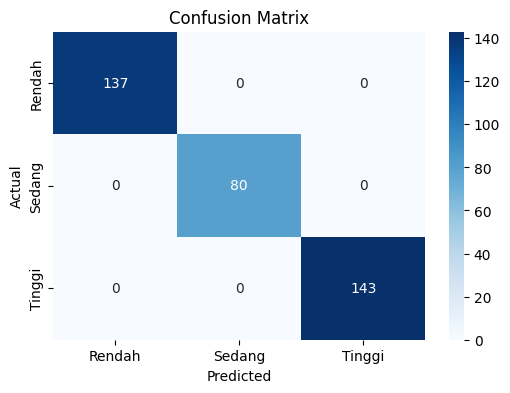


Classification Report:
              precision    recall  f1-score   support

      Rendah       1.00      1.00      1.00       137
      Sedang       1.00      1.00      1.00        80
      Tinggi       1.00      1.00      1.00       143

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load encoder jenis_pengadaan
le_jenis = joblib.load("le_jenis.pkl")
le_priority = joblib.load("le_priority.pkl")

# Siapkan fitur dan label
X = df[['nilai_kontrak']].copy()
X['jenis_pengadaan'] = le_jenis.transform(df['jenis_pengadaan'])  # encode string ke angka
y = df['Prioritas_encoded']

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model (Rule-Based): {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_priority.classes_, yticklabels=le_priority.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_priority.classes_))


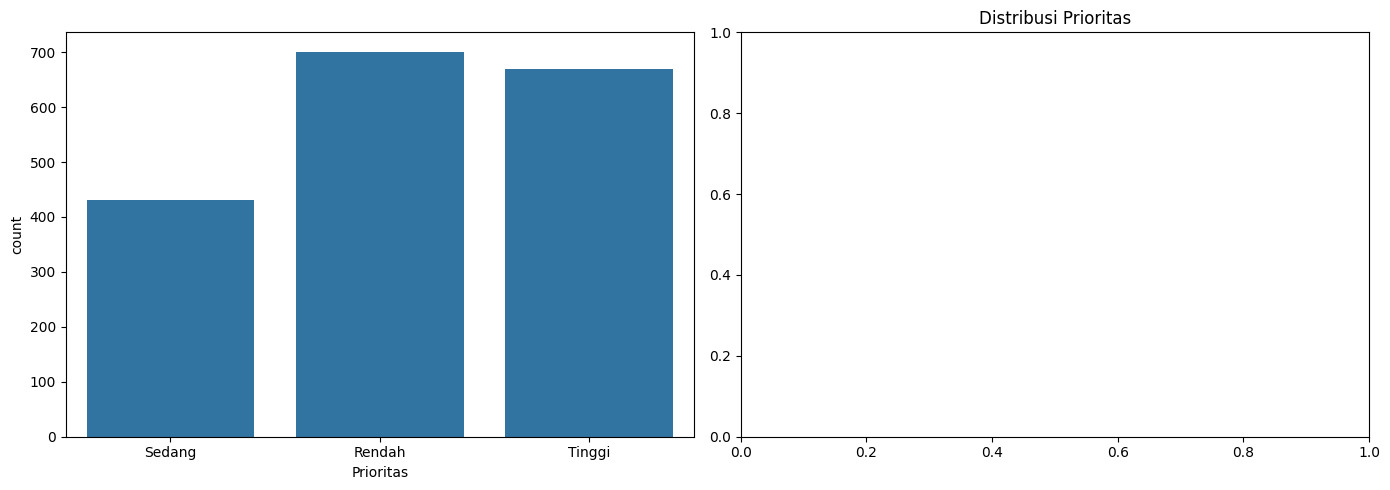

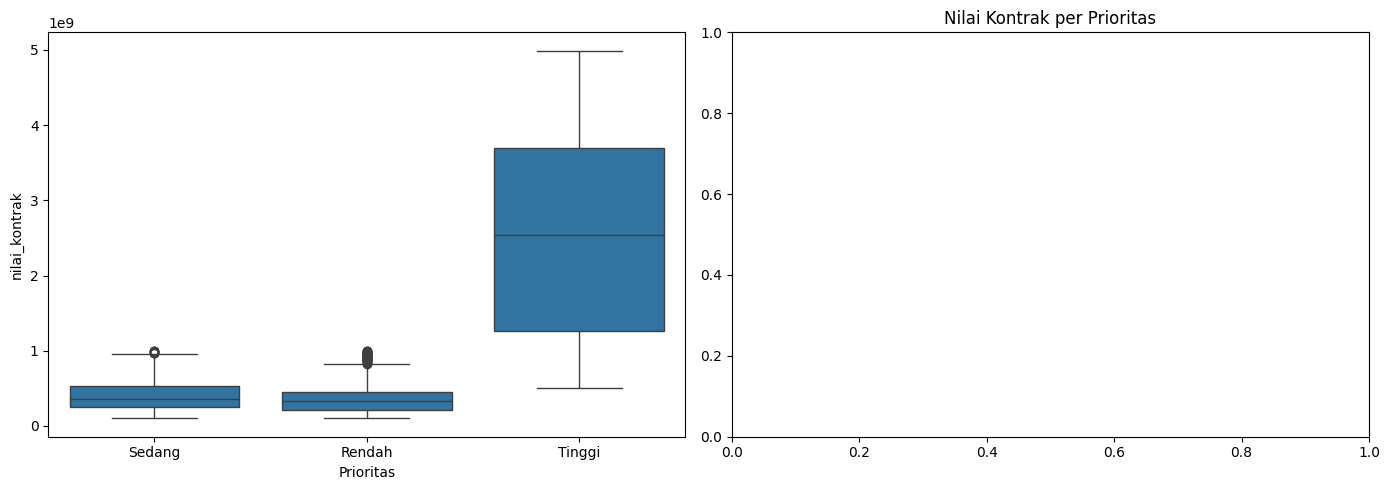

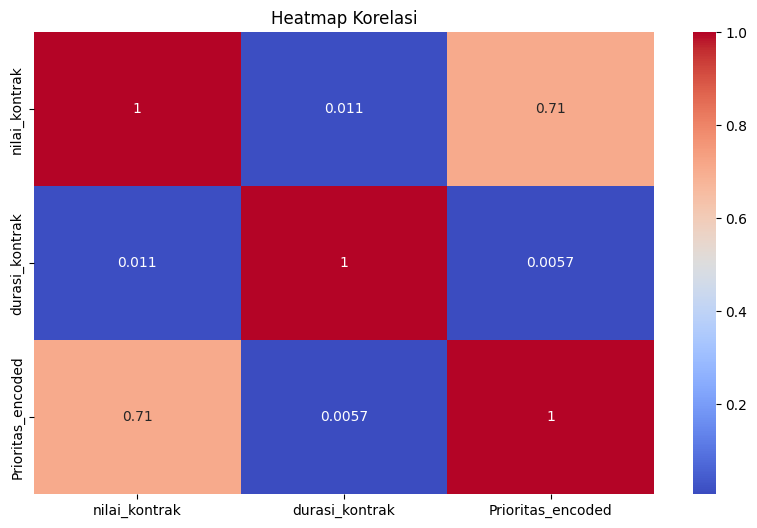

📊 Crosstab Prioritas:
Prioritas
Rendah    701
Tinggi    669
Sedang    430
Name: count, dtype: int64


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ukuran grafik default
plt.rcParams["figure.figsize"] = (10, 6)

# === 1. Distribusi Kategori ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='Prioritas', data=df, ax=axes[0])
axes[1].set_title("Distribusi Prioritas")
plt.tight_layout()
plt.show()

# === 2. Boxplot nilai_kontrak ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x='Prioritas', y='nilai_kontrak', data=df, ax=axes[0])
axes[1].set_title("Nilai Kontrak per Prioritas")
plt.tight_layout()
plt.show()

# === 3. Korelasi antar fitur numerik ===
corr = df[['nilai_kontrak', 'durasi_kontrak', 'Prioritas_encoded']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi")
plt.show()

# === 4. Crosstab Risk Level vs Prioritas ===
print("📊 Crosstab Prioritas:")
print(df['Prioritas'].value_counts())



# Model 2

⚙️ Applying SMOTE to training data to balance classes...
SMOTE applied. New training set size: (540, 3)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
✅ Cross-Validation Accuracy: 0.8537
✅ Test Accuracy: 0.7333
✅ Classification Report:
               precision    recall  f1-score   support

      Rendah       0.58      0.78      0.67         9
      Sedang       0.14      0.17      0.15         6
      Tinggi       0.88      0.80      0.84        45

    accuracy                           0.73        60
   macro avg       0.53      0.58      0.55        60
weighted avg       0.76      0.73      0.74        60



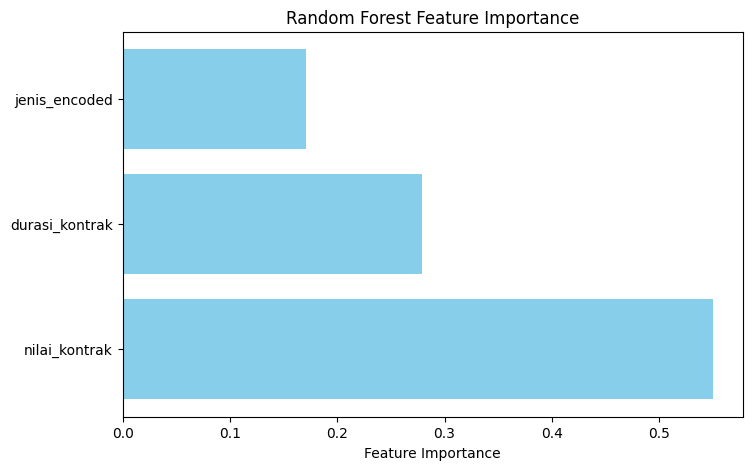

📊 Evaluasi Model terhadap Rule-Based Label pada 1500 Data Sisa:
✅ Accuracy: 0.8613333333333333
✅ Classification Report:
               precision    recall  f1-score   support

      Rendah       0.91      0.91      0.91       668
      Sedang       0.77      0.90      0.83       412
      Tinggi       0.90      0.76      0.82       420

    accuracy                           0.86      1500
   macro avg       0.86      0.85      0.85      1500
weighted avg       0.87      0.86      0.86      1500

✅ Confusion Matrix:
 [[605  59   4]
 [ 12 369  31]
 [ 49  53 318]]
✅ Model dan encoder berhasil disimpan!
✅ Data gabungan (1800 baris) disimpan ke Google Sheet pada sheet 'data_monitoring_kontrak_model2'


In [8]:
import pandas as pd
import numpy as np
import joblib
import re
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Parameter: aktifkan SMOTE atau tidak
use_smote = True

# ===== STEP 1: AUTH GOOGLE SHEETS =====
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# ===== STEP 2: BACA DATA DARI GOOGLE SHEETS (EXPORT CSV) =====
sheet_id = "1iracYHuwWxhqRI3_Zsm0A4pFaNQUW2Ie3Bl3n_p-fZU"  # Ganti dengan ID Sheet kamu
csv_url = f"https://docs.google.com/spreadsheets/d/1iracYHuwWxhqRI3_Zsm0A4pFaNQUW2Ie3Bl3n_p-fZU/export?format=csv"
df = pd.read_csv(csv_url)

def bersihkan_nilai_kontrak(nilai):
    if pd.isnull(nilai):
        return None
    nilai = str(nilai).replace(',00', '')
    nilai = re.sub(r'[^\d]', '', nilai)
    return int(nilai) if nilai else None

df['nilai_kontrak'] = df['nilai_kontrak'].apply(bersihkan_nilai_kontrak)
df.dropna(subset=['nilai_kontrak'], inplace=True)

# Ambil 300 data manual untuk training
df_manual = df.head(300).copy()
df_manual['tanggal_mulai'] = pd.to_datetime(df_manual['tanggal_mulai'])
df_manual['tanggal_berakhir'] = pd.to_datetime(df_manual['tanggal_berakhir'])
df_manual['durasi_kontrak'] = (df_manual['tanggal_berakhir'] - df_manual['tanggal_mulai']).dt.days

def rule_based_prioritas(row):
    jenis = row['jenis_pengadaan'].lower()
    nilai = row['nilai_kontrak']

    if jenis == 'pengembangan':
        if nilai >= 1_000_000_000:
            return 'Tinggi'
        elif nilai >= 500_000_000:
            return 'Sedang'
        else:
            return 'Rendah'
    elif jenis == 'maintenance':
        if nilai >= 500_000_000:
            return 'Tinggi'
        elif nilai <= 500_000_000:
            return 'Sedang'
        else:
            return 'Rendah'
    elif jenis == 'pembelian':
        if nilai >= 1_000_000_000:
            return 'Tinggi'
        else:
            return 'Rendah'
    else:
        return 'Rendah'

df_manual['Prioritas'] = df_manual.apply(rule_based_prioritas, axis=1)

# Tambahkan noise 10%
label_options = ['Rendah', 'Sedang', 'Tinggi']
num_noisy = int(0.1 * len(df_manual))
noise_indices = np.random.choice(df_manual.index, num_noisy, replace=False)
for idx in noise_indices:
    original = df_manual.loc[idx, 'Prioritas']
    df_manual.loc[idx, 'Prioritas'] = np.random.choice([l for l in label_options if l != original])

# Encoding label
le_prioritas = LabelEncoder()
df_manual['Prioritas_encoded'] = le_prioritas.fit_transform(df_manual['Prioritas'])

le_jenis = LabelEncoder()
df_manual['jenis_encoded'] = le_jenis.fit_transform(df_manual['jenis_pengadaan'])

features = df_manual[['nilai_kontrak', 'durasi_kontrak', 'jenis_encoded']]
labels = df_manual['Prioritas_encoded']

# Split train test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

# Terapkan SMOTE jika aktif
if use_smote:
    print("⚙️ Applying SMOTE to training data to balance classes...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("SMOTE applied. New training set size:", X_train.shape)

# Random Forest + Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

print("✅ Best Parameters:", random_search.best_params_)
print(f"✅ Cross-Validation Accuracy: {random_search.best_score_:.4f}")

# Evaluasi di test set
y_test_pred = best_model.predict(X_test)
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("✅ Classification Report:\n", classification_report(y_test, y_test_pred, target_names=le_prioritas.classes_))

# Feature importance plot
importances = best_model.feature_importances_
feature_names = ['nilai_kontrak', 'durasi_kontrak', 'jenis_encoded']

plt.figure(figsize=(8,5))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

# Prediksi untuk 1500 data sisa
df_sisa = df.iloc[300:].copy()
df_sisa['tanggal_mulai'] = pd.to_datetime(df_sisa['tanggal_mulai'])
df_sisa['tanggal_berakhir'] = pd.to_datetime(df_sisa['tanggal_berakhir'])
df_sisa['durasi_kontrak'] = (df_sisa['tanggal_berakhir'] - df_sisa['tanggal_mulai']).dt.days
df_sisa['jenis_encoded'] = le_jenis.transform(df_sisa['jenis_pengadaan'])

X_sisa = df_sisa[['nilai_kontrak', 'durasi_kontrak', 'jenis_encoded']]
df_sisa['Prioritas_Prediksi_encoded'] = best_model.predict(X_sisa)
df_sisa['Prioritas_Prediksi'] = le_prioritas.inverse_transform(df_sisa['Prioritas_Prediksi_encoded'])

# Tambahkan label rule-based ke df_sisa untuk evaluasi
df_sisa['Prioritas'] = df_sisa.apply(rule_based_prioritas, axis=1)
df_sisa['Prioritas_encoded'] = le_prioritas.transform(df_sisa['Prioritas'])

# Evaluasi performa model terhadap label rule-based di data sisa
y_true_sisa = df_sisa['Prioritas_encoded']
y_pred_sisa = df_sisa['Prioritas_Prediksi_encoded']

print("📊 Evaluasi Model terhadap Rule-Based Label pada 1500 Data Sisa:")
print("✅ Accuracy:", accuracy_score(y_true_sisa, y_pred_sisa))
print("✅ Classification Report:\n", classification_report(y_true_sisa, y_pred_sisa, target_names=le_prioritas.classes_))
print("✅ Confusion Matrix:\n", confusion_matrix(y_true_sisa, y_pred_sisa))

# Gabungkan kembali dengan 300 data awal
df_manual_final = df_manual[[
    'nomor_kontrak', 'nama_vendor', 'jenis_pengadaan', 'durasi_kontrak', 'tanggal_mulai', 'tanggal_berakhir', 'nilai_kontrak', 'jenis_encoded',
    'Prioritas', 'Prioritas_encoded'
]].copy()

df_manual_final['Prioritas_Prediksi'] = df_manual['Prioritas']
df_manual_final['Prioritas_Prediksi_encoded'] = df_manual['Prioritas_encoded']

df_sisa_final = df_sisa[[
    'nomor_kontrak', 'nama_vendor', 'jenis_pengadaan', 'durasi_kontrak', 'tanggal_mulai', 'tanggal_berakhir', 'nilai_kontrak', 'jenis_encoded',
    'Prioritas', 'Prioritas_encoded', 'Prioritas_Prediksi', 'Prioritas_Prediksi_encoded'
]].copy()

df_gabungan = pd.concat([df_manual_final, df_sisa_final], axis=0, ignore_index=True)

# Simpan model dan encoder
joblib.dump(best_model, 'model_prioritas_rf_tuned.pkl')
joblib.dump(le_prioritas, 'label_encoder_prioritas.pkl')
joblib.dump(le_jenis, 'label_encoder_jenis.pkl')

print("✅ Model dan encoder berhasil disimpan!")

# ===== SIMPAN KE GOOGLE SHEETS (SHEET BARU) =====
sheet_id = "1iracYHuwWxhqRI3_Zsm0A4pFaNQUW2Ie3Bl3n_p-fZU"  # Ganti dengan ID Sheet Google kamu
spreadsheet = gc.open_by_key(sheet_id)

sheet_names = [ws.title for ws in spreadsheet.worksheets()]
base_sheet_name = "data_monitoring_kontrak_model2"

if base_sheet_name in sheet_names:
    new_sheet_name = base_sheet_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S")
else:
    new_sheet_name = base_sheet_name

worksheet = spreadsheet.add_worksheet(title=new_sheet_name, rows=str(len(df_gabungan)+10), cols="30")
set_with_dataframe(worksheet, df_gabungan)

print(f"✅ Data gabungan ({len(df_gabungan)} baris) disimpan ke Google Sheet pada sheet '{new_sheet_name}'")

# Streamlit

In [35]:
%%writefile app.py

import streamlit as st
import pandas as pd
import plotly.express as px
import gspread
from google.oauth2.service_account import Credentials
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# ===========================
# Fungsi Kirim Email (dengan App Password)
# ===========================
def kirim_email_daftar_kontrak(receiver_email, df_kontrak):
    sender_email = "pratamabayu.sb@gmail.com"
    app_password = "pewf eems axad lvsk"  # ← Ganti dengan App Password dari Google

    subject = "Notifikasi: Kontrak Prioritas Tinggi"
    body = "Berikut ini adalah daftar kontrak prioritas tinggi:\n\n" + df_kontrak.to_string(index=False)

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.login(sender_email, app_password)
            server.send_message(msg)
        return True
    except Exception as e:
        st.error(f"Gagal mengirim email: {e}")
        return False

# ===========================
# CSS Styling
# ===========================
st.markdown("""
    <style>
        .main { background-color: #f4f6f8; }
        h1 { color: #2c3e50; }
        .metric-box {
            background-color: white;
            border-radius: 12px;
            padding: 20px;
            box-shadow: 0 2px 6px rgba(0, 0, 0, 0.1);
            margin-bottom: 16px;
            text-align: center;
        }
        .metric-box h3 {
            margin: 0;
            font-size: 18px;
            color: #555;
        }
        .metric-box p {
            font-size: 24px;
            font-weight: bold;
            margin: 4px 0 0 0;
        }
        .rendah { background-color: #d4edda; }
        .sedang { background-color: #fff3cd; }
        .tinggi { background-color: #f8d7da; }

        .block-container {
            padding-top: 2rem;
            padding-bottom: 2rem;
            padding-left: 2rem !important;
            padding-right: 2rem !important;
            max-width: 100% !important;
        }

        .stMetric { padding: 0px; }
    </style>
""", unsafe_allow_html=True)

# ===========================
# Load Data dari Google Sheets
# ===========================
@st.cache_data
def load_data():
    scope = [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive"
    ]
    creds = Credentials.from_service_account_file("monitoringkontrakproject-7bf5b72cd479.json", scopes=scope)
    client = gspread.authorize(creds)

    sheet = client.open("data_dummy_monitoring_kontrak_it_bank_xyz")

    try:
        worksheet = sheet.worksheet("data_monitoring_kontrak_model2")
    except gspread.exceptions.WorksheetNotFound:
        worksheet = sheet.get_worksheet(1)  # fallback ke worksheet kedua

    data = worksheet.get_all_records()
    return pd.DataFrame(data)

df = load_data()

# ===========================
# Sidebar Filter & Akses Sheet
# ===========================
st.sidebar.title("🔎 Filter Kontrak")
vendor = st.sidebar.multiselect("Nama Vendor", df["nama_vendor"].unique())
jenis = st.sidebar.multiselect("Jenis Pengadaan", df["jenis_pengadaan"].unique())
prioritas = st.sidebar.multiselect("Prioritas", df["Prioritas_Prediksi"].unique())

st.sidebar.markdown("---")
st.sidebar.subheader("📄 Akses Google Sheet")

sheet_url = "https://docs.google.com/spreadsheets/d/1iracYHuwWxhqRI3_Zsm0A4pFaNQUW2Ie3Bl3n_p-fZU/edit#gid=1372451459"
st.sidebar.markdown(
    f"""
    <a href="{sheet_url}" target="_blank">
        <button style="background-color:#4CAF50;color:white;padding:10px 16px;border:none;border-radius:8px;cursor:pointer;">
            🔗 Buka Google Sheet
        </button>
    </a>
    """,
    unsafe_allow_html=True
)

# ===========================
# Filter Data
# ===========================
filtered_df = df.copy()
if vendor:
    filtered_df = filtered_df[filtered_df["nama_vendor"].isin(vendor)]
if jenis:
    filtered_df = filtered_df[filtered_df["jenis_pengadaan"].isin(jenis)]
if prioritas:
    filtered_df = filtered_df[filtered_df["Prioritas_Prediksi"].isin(prioritas)]

# ===========================
# Dashboard Header
# ===========================
st.title("📊 Dashboard Monitoring Kontrak IT")

col1, col2, col3, col4 = st.columns(4)

with col1:
    st.markdown('<div class="metric-box"><h3>Total Kontrak</h3><p>{}</p></div>'.format(len(filtered_df)), unsafe_allow_html=True)

with col2:
    jumlah_rendah = (filtered_df["Prioritas_Prediksi"] == "Rendah").sum()
    st.markdown(f'<div class="metric-box rendah"><h3>Prioritas Rendah</h3><p>{jumlah_rendah} kontrak</p></div>', unsafe_allow_html=True)

with col3:
    jumlah_sedang = (filtered_df["Prioritas_Prediksi"] == "Sedang").sum()
    st.markdown(f'<div class="metric-box sedang"><h3>Prioritas Sedang</h3><p>{jumlah_sedang} kontrak</p></div>', unsafe_allow_html=True)

with col4:
    jumlah_tinggi = (filtered_df["Prioritas_Prediksi"] == "Tinggi").sum()
    st.markdown(f'<div class="metric-box tinggi"><h3>Prioritas Tinggi</h3><p>{jumlah_tinggi} kontrak</p></div>', unsafe_allow_html=True)

st.divider()

# ===========================
# Visualisasi Perbandingan Model
# ===========================
st.header("📘 Evaluasi dan Perbandingan Model")

col1, col2 = st.columns(2)

with col1:
    st.subheader("📍 Model 1 - Rule-Based")
    model1_counts = filtered_df["Prioritas"].value_counts().reset_index()
    model1_counts.columns = ["Prioritas", "Jumlah"]
    fig_m1 = px.histogram(
        model1_counts,
        x="Prioritas",
        y="Jumlah",
        color="Prioritas",
        color_discrete_map={
            "Rendah": "#27ae60",
            "Sedang": "#f39c12",
            "Tinggi": "#e74c3c"
        }
    )
    st.plotly_chart(fig_m1, use_container_width=True)

with col2:
    st.subheader("📍 Model 2 - ML Predict")
    model2_counts = filtered_df["Prioritas_Prediksi"].value_counts().reset_index()
    model2_counts.columns = ["Prioritas", "Jumlah"]
    fig_m2 = px.pie(
        model2_counts,
        names="Prioritas",
        values="Jumlah",
        color="Prioritas",
        color_discrete_map={
            "Rendah": "#27ae60",
            "Sedang": "#f39c12",
            "Tinggi": "#e74c3c"
        }
    )
    st.plotly_chart(fig_m2, use_container_width=True)

# ===========================
# Treemap Vendor vs Prioritas
# ===========================
st.subheader("🧩 Treemap Vendor vs Prioritas")
fig_vendor = px.treemap(
    filtered_df,
    path=["nama_vendor", "Prioritas_Prediksi"],
    values="nilai_kontrak",
    color="Prioritas_Prediksi",
    color_discrete_map={
        "Rendah": "#27ae60",
        "Sedang": "#f39c12",
        "Tinggi": "#e74c3c"
    }
)
st.plotly_chart(fig_vendor, use_container_width=True)

# ===========================
# Tren Kontrak per Bulan
# ===========================
st.subheader("📈 Tren Jumlah Kontrak per Bulan")
df["tanggal_mulai"] = pd.to_datetime(df["tanggal_mulai"], errors="coerce")
df["bulan_mulai"] = df["tanggal_mulai"].dt.to_period("M").astype(str)
trend = df.groupby("bulan_mulai").size().reset_index(name="jumlah_kontrak")
fig_trend = px.line(trend, x="bulan_mulai", y="jumlah_kontrak", markers=True)
st.plotly_chart(fig_trend, use_container_width=True)

# ===========================
# Top 50 Kontrak Prioritas Tinggi
# ===========================
if "Prioritas_Prediksi" in df.columns:
    top50_prediksi = df[df["Prioritas_Prediksi"] == "Tinggi"].sort_values(by="nilai_kontrak", ascending=False).head(50)

    st.subheader("🔍 Top 50 Kontrak Prioritas Tinggi (Model 2)")
    if not top50_prediksi.empty:
        st.dataframe(top50_prediksi[[
            "nomor_kontrak", "nama_vendor", "jenis_pengadaan", "Prioritas_Prediksi"
        ]], use_container_width=True)

        # Input email dan kirim
        st.subheader("✉️ Kirim Notifikasi Email")
        receiver_email = st.text_input("Masukkan email tujuan:")
        if st.button("Kirim Email"):
            if receiver_email:
                sukses = kirim_email_daftar_kontrak(receiver_email, top50_prediksi[[
                    "nomor_kontrak", "nama_vendor", "jenis_pengadaan", "Prioritas_Prediksi"
                ]])
                if sukses:
                    st.success("✅ Email berhasil dikirim.")
            else:
                st.warning("⚠️ Masukkan alamat email terlebih dahulu.")
    else:
        st.warning("⚠️ Tidak ada data Prioritas Tinggi dari hasil Prediksi Model 2.")
else:
    st.error("❌ Kolom 'Prioritas_Prediksi' tidak ditemukan.")

# ===========================
# Download CSV
# ===========================
st.download_button(
    label="📅 Download Data (CSV)",
    data=top50_prediksi.to_csv(index=False),
    file_name="top50_kontrak_prioritas_tinggi.csv",
    mime="text/csv"
)


Overwriting app.py


In [36]:
!ls -l app.py

-rw-r--r-- 1 root root 8896 Jun  5 03:12 app.py


In [37]:
!pip install streamlit pyngrok --quiet

# Wajib dijalankan di CELL TERSENDIRI (jangan digabung dengan ngrok.connect)
!ngrok config add-authtoken 2vuWRJYrm9bVZVH53meU2yfdnQR_5W3rgCAatY6VAvA8bESJv

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [38]:
from pyngrok import ngrok
import time

# Tutup tunnel lama dulu biar bersih
ngrok.kill()

# Buka tunnel baru
public_url = ngrok.connect(8501)
print("🌍 Streamlit kamu bisa diakses di:", public_url)

# Mulai streamlit
!streamlit run app.py &>/content/logs.txt &

# Tunggu sebentar supaya proses stabil
time.sleep(5)

# Cek log terakhir
!tail -n 10 /content/logs.txt


🌍 Streamlit kamu bisa diakses di: NgrokTunnel: "https://c0bd-34-69-185-125.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.69.185.125:8501



In [34]:
!pkill streamlit
!pkill ngrok